In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, auc
from sklearn.metrics import precision_score, recall_score

In [2]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.4):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 112 -> 56
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # 56 -> 28
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # 28 -> 14
        x = x.view(-1, 64 * 14 * 14)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [3]:
best_model_path = 'best_model.pt'  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN(dropout_rate=0.35).to(device)
model.load_state_dict(torch.load(best_model_path, weights_only=True))

<All keys matched successfully>

In [4]:
test_df = pd.read_csv("test_dataset.csv")

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, c_type="RGB"):
        self.df = df
        self.transform = transform
        self.c_type = c_type
        self.classes = df["label"].unique

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, id):
        img_path = self.df.iloc[id]["file_path"]
        label = self.df.iloc[id]["label"]
        if self.c_type.upper() == "RGB":
            image = Image.open(img_path).convert('RGB')
        else:
            image = Image.open(img_path).convert(self.c_type)
            
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.Normalize((0.5), (0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter()
])

In [7]:
test_dataset = CustomDataset(test_df, transform=transform, c_type="L")

In [8]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

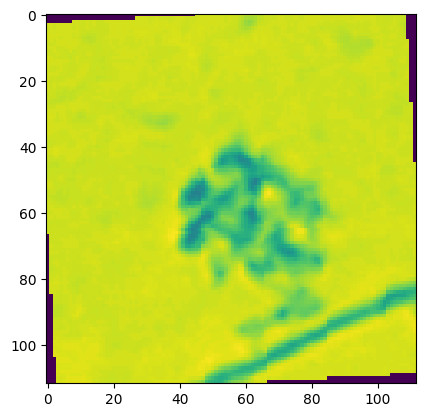

In [11]:
images, labels = next(iter(test_loader))
plt.imshow(images[0].permute(1, 2, 0))

In [ ]:
criterion = nn.CrossEntropyLoss()
correct_test = 0
total_test = 0
test_loss = 0.0
all_test_labels = []
all_test_preds = []
all_test_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        
        total_test += labels.size(0)
        correct_test += (preds == labels).sum().item()
        all_test_labels.extend(labels.detach().cpu().numpy())
        all_test_preds.extend(preds.detach().cpu().numpy())
        all_test_probs.extend(probs.detach().cpu().numpy())

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')

test_auc = roc_auc_score(
    np.eye(3)[all_test_labels],   
    np.array(all_test_probs),     
    multi_class='ovr'
)

print("\nTest Results:")
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test F1 Score: {test_f1:.3f}')
print(f'Test ROC AUC: {test_auc:.3f}')
print("Test Confusion Matrix:\n", confusion_matrix(all_test_labels, all_test_preds))


Test Results:
Test Loss: 0.488
Test Accuracy: 82.06%
Test F1 Score: 0.822
Test ROC AUC: 0.935
Test Confusion Matrix:
 [[162  45   7]
 [ 17 186   9]
 [ 14  21 169]]


In [15]:
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=['Normal_Sperm', 'Abnormal_Sperm','Non-Sperm']))


Classification Report:
                precision    recall  f1-score   support

  Normal_Sperm       0.84      0.76      0.80       214
Abnormal_Sperm       0.74      0.88      0.80       212
     Non-Sperm       0.91      0.83      0.87       204

      accuracy                           0.82       630
     macro avg       0.83      0.82      0.82       630
  weighted avg       0.83      0.82      0.82       630



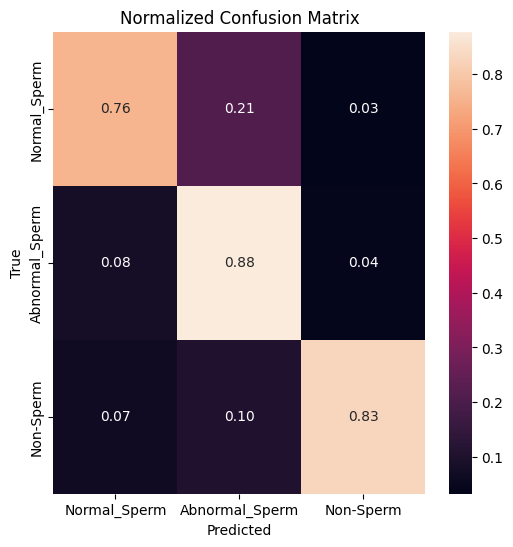

In [30]:
cm = confusion_matrix(all_test_labels, all_test_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 6))
# sns.heatmap(cmn, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal_Sperm', 'Abnormal_Sperm','Non-Sperm'], yticklabels=['Normal_Sperm', 'Abnormal_Sperm','Non-Sperm'])
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['Normal_Sperm', 'Abnormal_Sperm','Non-Sperm'], yticklabels=['Normal_Sperm', 'Abnormal_Sperm','Non-Sperm'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'../images/best_model_normalized_confusion_matrix.png')
plt.show()

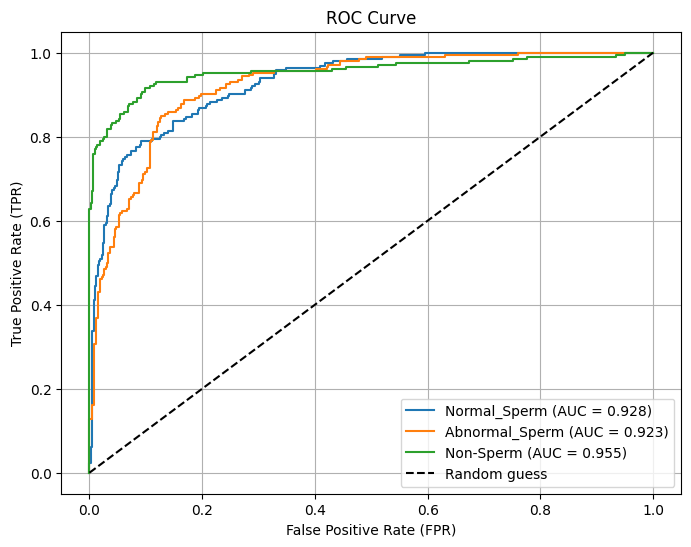

In [31]:
class_names = ['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm']
all_test_labels = np.array(all_test_labels)
all_test_probs = np.array(all_test_probs)

plt.figure(figsize=(8, 6))

for i in range(3): 
    binary_labels = (all_test_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.grid()
plt.savefig(f'../images/best_model_roc_curve.png')
plt.show()
